# Reinforcement Learning &#x2013; Q-Learning

**Prerequisites**

- Linear Algebra
- Statistics and Probability
- Dynamic Programming
- Reinforcement Learning Introduction
- Reinforcement Learning Sarsa algorithm

**Outcomes**

- Know the difference between on policy and off policy learning
- Learn the Q-learning algorithm for off policy TD based control

**References**

- Barto & Sutton book (online by authors [here](http://incompleteideas.net/book/the-book.html)) chapters 4-6

## Recap

- In the RL problem agent observes $S$, makes decision $A$, sees reward and next state $R$, $S'$ -- then process repeats $S, A, R, S', A', ...$
- Sarsa uses a $(S, A, R, S', A')$ quintuple to learn $Q(s, a)$ that approximates $q^*(s, a)$
- Notice Sarsa uses $\epsilon$-greedy policy to propose $a'$ **AND** uses that $A'$ when updating $Q$
![sarsa_barto_sutton.png](./sarsa_barto_sutton.png)

### On-policy vs off-policy methods

- Because Sarsa uses the $Q$ about which it is learning to generate $A'$, it is known as an *on-policy* learning method
- On policy: make decisions based on value (policy) function being learned
- Alternative: follow any policy for proposing $A'$, but use the greedy policy derived from $Q$ when computing $TD(0)$...
- This is what we'll explore today

## Q-learning

- An early theoretical breakthrough in RL was the idea of off-policy learning
- The Q-learning algorithm was the first off-policy control algorithm to be suggested
- It allows the algorithm to make use of $S, A, R, S'$ transitions obtained from *any* source, and still learn an approximation $Q$ that converges to $q^*$ with probability 1
- Convergence requires some conditions, most importantly that the transitions $S, A, R, S'$ *cover* the action space of $q^*$
- *Coverage* means all (s, a) pairs that are optimal under $q^*$ must be visited by the $S, A, R, S'$ transitions

### Example: Self-Driving Car

- Goal: train RL agent to safely drive vechicle
- Sarsa method:
    - Give control of vehicle over to Sarsa, so it can choose $A$ and observe implied $R$, $S'$ transitions
- Off-policy:
    - Let human expert driver drive vehicle in intended way
    - Record $S, A, R, S'$ transitions visited by human driver
    - Train RL agent based on data generated from human experience

### The Q-learning Algorithm

![q-learning_barto_sutton.png](./q-learning_barto_sutton.png)

- $A$ that are suggested are $\epsilon$-greedy in $Q$
- This is a *suggestion* for how to generate $A$, but anything else (including totally random) could be used
- When updating the $t+1$ component of $TD(0)(Q)$ there is an explicit $max_{a'} Q(S', a')$ -- it is always *greedy*
<!-- - By computing $TD(0)(Q)$ updates that are greedy in $Q$, Q-learning can converge to $q^*$ regardless of how $A$ are generated -->

## Q-learning Farkle

- Let's implement the Q-learning algorithm to solve our farkle game
- First, some code optimizations:
    1. `farkle.py` has been updated to include a method `State.observable_state`
        - This method returns a tuple containing only how many dice are rollable, sum collected in turn, and what rolled dice are showing
        - Drops scores, round, etc.
        - Implication -- we will have agent learn to maximize score each turn
        - If agent scores high every turn, should be able to win game
        - Loses ability to customize behavior based on "stage" of game (aggressive play to catch up, or conservative to maintain lead)
    2. Creatd a `TablularQ` class below that uses this `State.observable_state` method
        - Allows RL algorithms to not worry about `State.observable_state`
    3. Remove history tracking from `FarkleEnv` (see `FarkleEnv` in farkle.py file)

In [1]:
from collections import defaultdict
import random

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class TabularQ:
    def __init__(self, default_value= lambda: 0):
        val = default_value if callable(default_value) else lambda x: defaul_value
        self.Q = defaultdict(lambda: default_value)
    
    def __call__(self, s, a):
        return self.Q[(s.observable_state(), a)]

    def __setitem__(self, k, v):
        s, a = k
        self.Q[(s.observable_state(), a)] = v
        
    def get_greedy(self, s, A_s):
        vals = [self(s, a) for a in A_s]
        max_val = max(vals)
        return random.choice([a for (a, v) in zip(A_s, vals) if v == max_val])    

### Q-learning implementation

- We implement Q-learning in the `QLearning` class below

In [3]:
class Qlearning(object):
    def __init__(self, environment, default_value=0, epsilon=0.9, alpha=0.1, beta=1.0):
        self.env = environment
        self.Q = TabularQ(default_value=default_value)
        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        
        self.restart_episode()    

    def restart_episode(self):
        self.s = self.env.reset()

    def get_greedy(self, s, A_s):
        return self.Q.get_greedy(s, A_s)
    
    def generate_A(self, s, A_s):
        if random.random() > self.epsilon:
            return random.choice(A_s)
        return self.get_greedy(s, A_s)

    def done(self, s=None) -> bool:
        return self.env.done(s if s else self.s)
    
    def step(self):
        s = self.s
        # first generate an A
        A_s = self.env.enumerate_options(s)
        a = self.generate_A(s, A_s)

        # take step
        sp, r = self.env.step(s, a)
        
        if self.done(sp):
            # game is over
            self.s = sp
            return
        
        # get greedy a' based on Q and sp
        A_sp = self.env.enumerate_options(sp)
        ap = self.get_greedy(sp, A_sp)
        
        # Do TD update
        Q, α, β = self.Q, self.alpha, self.beta  # simplify notation
        Q[(s, a)] = Q(s, a) + α * (r + β * Q(sp, ap) - Q(s, a))
        
        # step forward in time
        self.s = sp 

### Single Game test

In [4]:
from farkle import FarkleEnv, play_game, play_many_games

In [5]:
random.seed(40)

env = FarkleEnv(track_history=False)
ql = Qlearning(env)
play_game(ql)
ql.s

Round: 86. Score: [10050, 9300]

### Longer training

- Let's now let our qlearning algorithm train on 5,000 games

In [9]:
%%time

random.seed(42)  # reset seed for reproducibility
qlearning_history = play_many_games(ql, 5000)

Done with 0/5000 (len(Q) = 8273)
Done with 500/5000 (len(Q) = 8634)
Done with 1000/5000 (len(Q) = 8871)
Done with 1500/5000 (len(Q) = 9193)
Done with 2000/5000 (len(Q) = 9585)
Done with 2500/5000 (len(Q) = 9871)
Done with 3000/5000 (len(Q) = 10187)
Done with 3500/5000 (len(Q) = 10561)
Done with 4000/5000 (len(Q) = 10865)
Done with 4500/5000 (len(Q) = 11154)
CPU times: user 2min 33s, sys: 2.4 s, total: 2min 36s
Wall time: 2min 57s


In [10]:
def plot_win_rate(history):
    won = np.array([s.scores[0] > s.scores[1] for s in history])
    game_idx = np.arange(len(won))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(game_idx, won.cumsum())
    ax.plot(game_idx, 0.5 * game_idx)
    plt.legend(["algo", "E[random agent]"])
    print(f"won {sum(won)}/{len(won)} games")

won 4199/5000 games


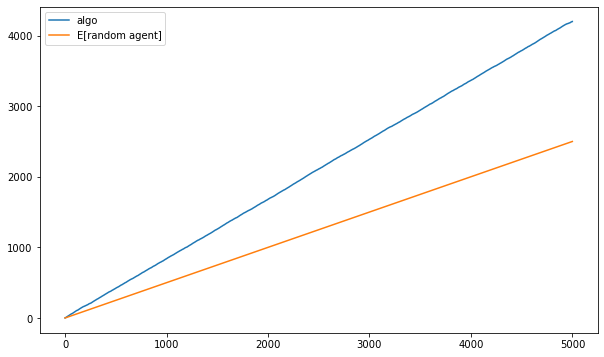

In [11]:
plot_win_rate(qlearning_history)

- Excellent! Our Q-learning algorithm seems to be doing quite a bit better than we would expect a random agent to do